Normal Gravity


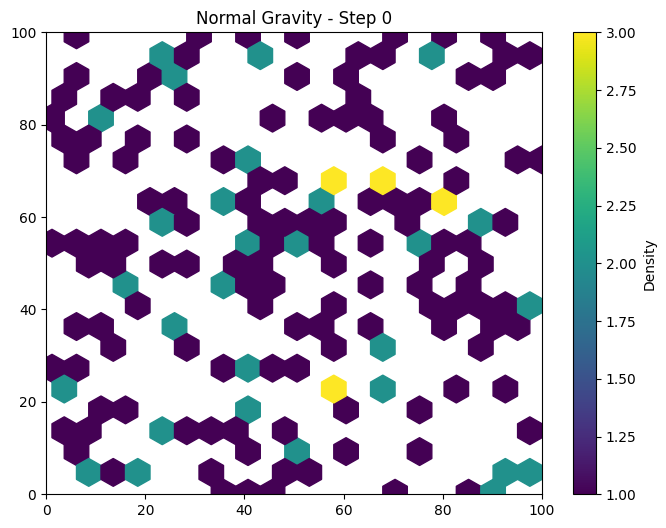

Normal Gravity - Step 0:
  Population: 200
  Bond Events: 0
  Avg Resources: 0.50
  Avg Chain Length: 0.00
  Max Chain Length: 0


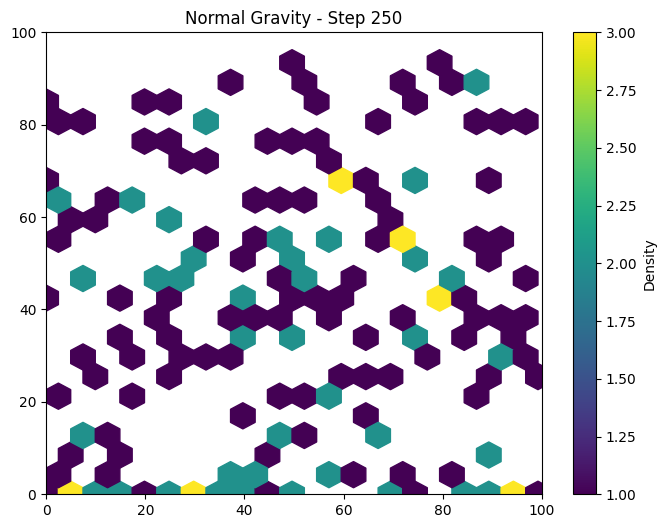

Normal Gravity - Step 250:
  Population: 198
  Bond Events: 170
  Avg Resources: 132.22
  Avg Chain Length: 4.58
  Max Chain Length: 25


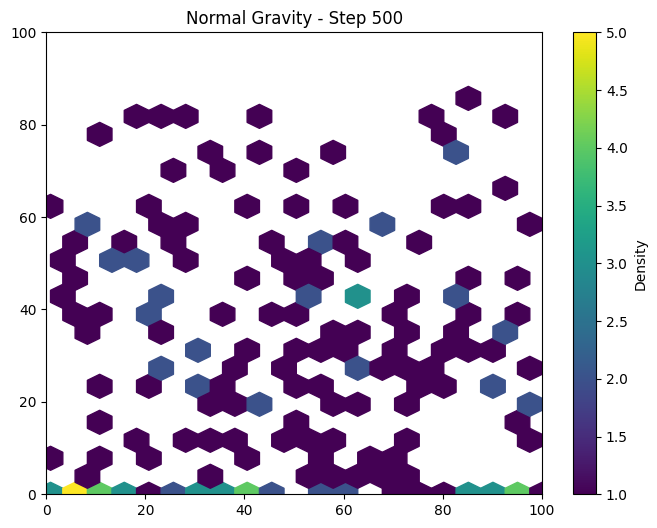

Normal Gravity - Step 500:
  Population: 198
  Bond Events: 338
  Avg Resources: 289.82
  Avg Chain Length: 14.75
  Max Chain Length: 66


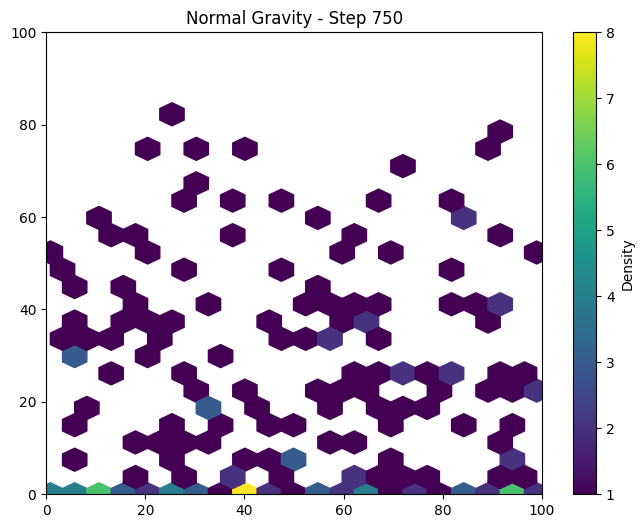

Normal Gravity - Step 750:
  Population: 198
  Bond Events: 559
  Avg Resources: 466.03
  Avg Chain Length: 93.00
  Max Chain Length: 180


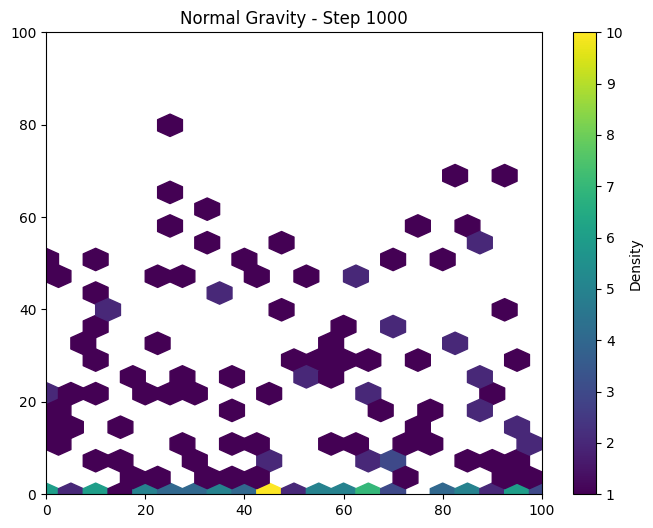

Normal Gravity - Step 1000:
  Population: 198
  Bond Events: 826
  Avg Resources: 656.96
  Avg Chain Length: 96.00
  Max Chain Length: 185


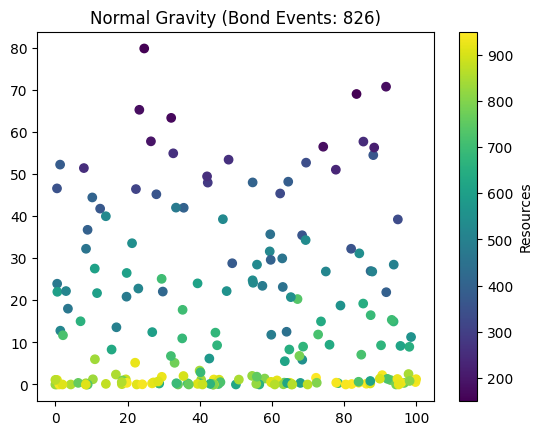

Final - Bond Events: 826, Population: 198, Avg Resources: 656.96, Avg Mass: 0.00, Avg Chain Length: 96.00, Max Chain Length: 185

Microgravity


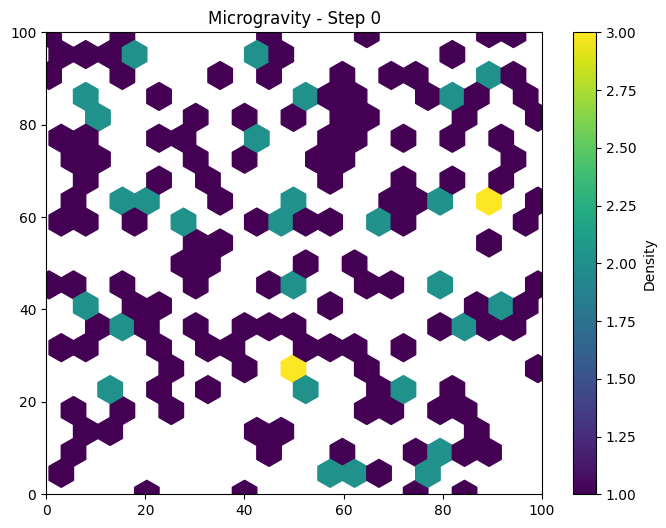

Microgravity - Step 0:
  Population: 200
  Bond Events: 0
  Avg Resources: 0.50
  Avg Chain Length: 0.00
  Max Chain Length: 0


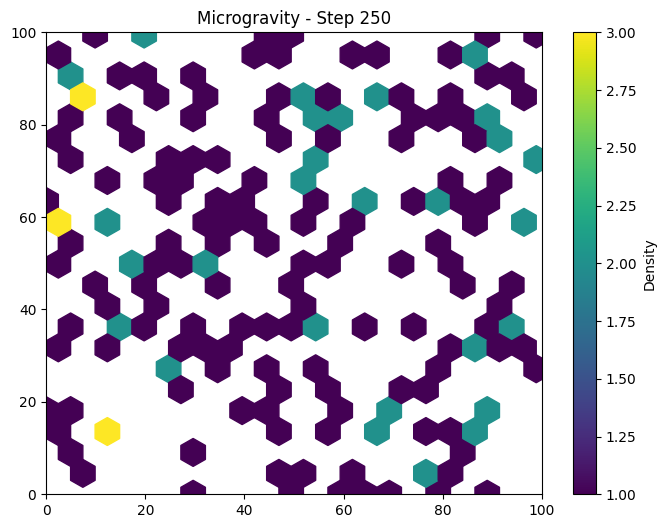

Microgravity - Step 250:
  Population: 200
  Bond Events: 120
  Avg Resources: 119.50
  Avg Chain Length: 3.22
  Max Chain Length: 7


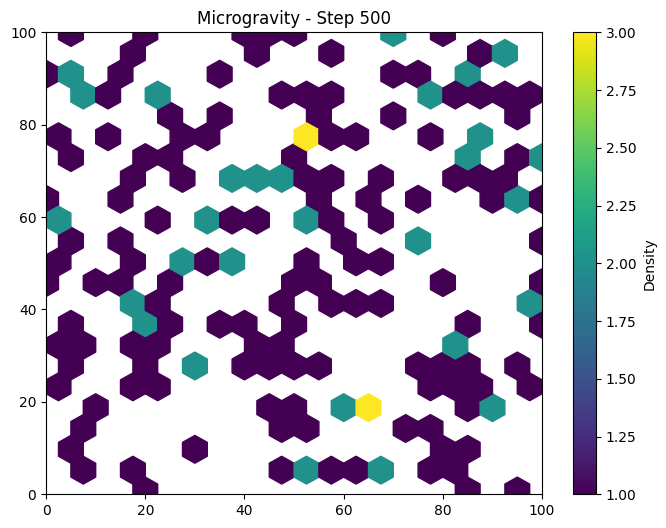

Microgravity - Step 500:
  Population: 200
  Bond Events: 198
  Avg Resources: 240.60
  Avg Chain Length: 8.40
  Max Chain Length: 50


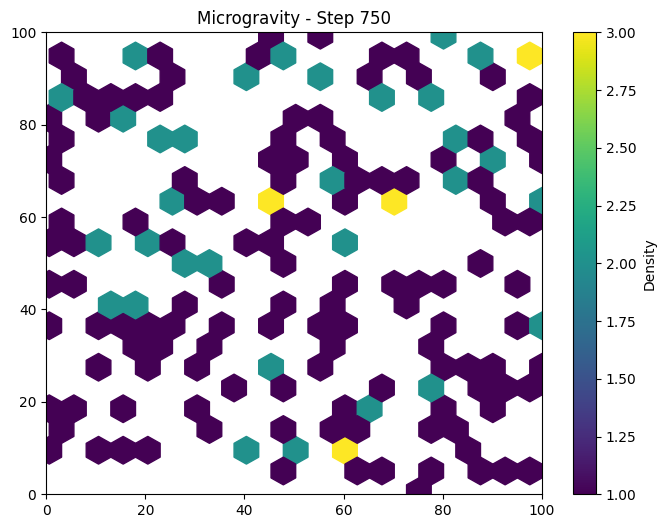

Microgravity - Step 750:
  Population: 200
  Bond Events: 266
  Avg Resources: 362.20
  Avg Chain Length: 20.67
  Max Chain Length: 110


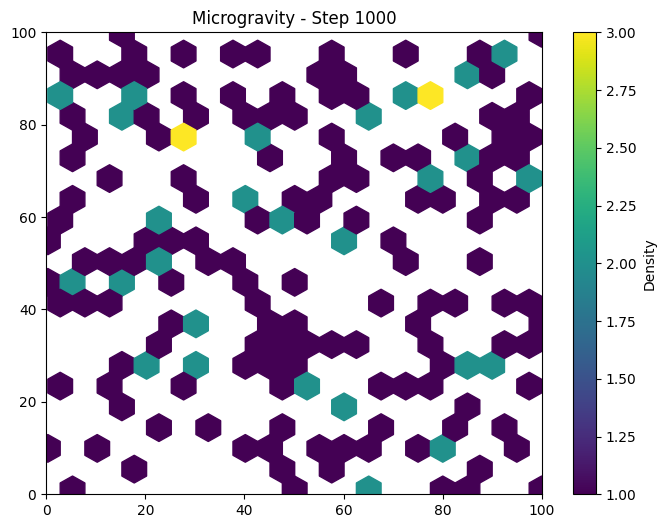

Microgravity - Step 1000:
  Population: 200
  Bond Events: 348
  Avg Resources: 483.10
  Avg Chain Length: 63.67
  Max Chain Length: 187


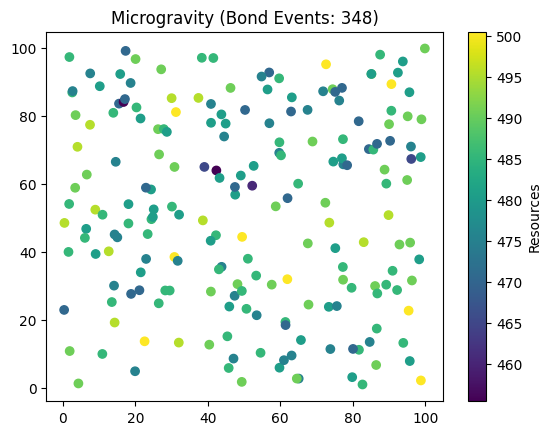

Final - Bond Events: 348, Population: 200, Avg Resources: 483.10, Avg Mass: 0.00, Avg Chain Length: 63.67, Max Chain Length: 187


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, deque
from scipy.spatial import KDTree

G_NORMAL = 0.05  # Gravity strength pulling toward y=0
G_MICRO = 0     # No gravity

class Particle:
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.mass = np.random.uniform(0.5, 1.5)
        self.resources = 0
        self.pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
        self.bonds = set()  # Changed from list to set for O(1) lookups

    def step(self):
        # Gravity pulls downward
        if self.model.G != G_MICRO:
            gravity_force = -self.model.G * self.mass
            self.pos[1] += gravity_force
        self.pos += np.random.uniform(-0.5, 0.5, 2)
        self.pos = np.clip(self.pos, 0, 99.999)

        # Resource uptake
        resource_density = max(0, 10 - self.pos[1] / 10) if self.model.G != G_MICRO else 5
        self.resources += resource_density * 0.1

class MolecularModel:
    def __init__(self, N_particles, G):
        self.G = G
        self.particles = []
        self.particle_dict = {}  # For O(1) particle lookup by ID
        self.bond_events = 0
        self.removed_particles = set()  # Track removed particles

        for i in range(N_particles):
            particle = Particle(i, self)
            self.particles.append(particle)
            self.particle_dict[i] = particle

    def step(self):
        # Update particle positions first (avoid proximity checks during movement)
        for particle in self.particles:
            particle.step()
        
        # Build KDTree for efficient proximity queries - O(n log n) construction
        positions = np.array([p.pos for p in self.particles])
        if len(positions) > 0:  # Check for empty array
            tree = KDTree(positions)
            
            # Process interactions using nearest neighbors
            for i, particle in enumerate(self.particles):
                if particle.unique_id in self.removed_particles:
                    continue
                    
                # Query tree for neighbors within radius 1.0 - O(log n) per query
                indices = tree.query_ball_point(particle.pos, 1.0)
                
                for j in indices:
                    if i == j or self.particles[j].unique_id in self.removed_particles:
                        continue
                        
                    other = self.particles[j]
                    
                    # Bonding logic
                    if (particle.resources > 5 and other.resources > 5 and 
                            other.unique_id not in particle.bonds):
                        particle.bonds.add(other.unique_id)
                        other.bonds.add(particle.unique_id)
                        particle.resources -= 5
                        other.resources -= 5
                        self.bond_events += 1
                        break
                    # Feeding logic
                    elif particle.resources > 10 and other.resources < 3:
                        particle.resources += other.resources
                        particle.mass += other.mass * 0.5
                        self.removed_particles.add(other.unique_id)
                        break
            
            # Remove particles marked for removal
            if self.removed_particles:
                # Clean up bonds referencing removed particles
                for p in self.particles:
                    p.bonds -= self.removed_particles
                
                # Filter out removed particles
                self.particles = [p for p in self.particles if p.unique_id not in self.removed_particles]
                
                # Update particle dictionary
                for uid in self.removed_particles:
                    if uid in self.particle_dict:
                        del self.particle_dict[uid]
                
                self.removed_particles.clear()


def analyze_chains(particles):
    """Analyze chains using BFS - O(n + e) where e is number of bonds"""
    chain_lengths = []
    visited = set()
    
    for p in particles:
        if p.unique_id not in visited and p.bonds:
            # Start BFS from this particle
            chain = []
            queue = deque([p.unique_id])
            visited.add(p.unique_id)
            
            while queue:
                current_id = queue.popleft()
                chain.append(current_id)
                
                # Get the current particle
                current = next((p for p in particles if p.unique_id == current_id), None)
                if current:
                    for bond_id in current.bonds:
                        if bond_id not in visited:
                            visited.add(bond_id)
                            queue.append(bond_id)
                            
            chain_lengths.append(len(chain))
    
    return chain_lengths


def plot_heatmap(particles, step_num, label):
    if not particles:
        print(f"No particles to plot at step {step_num}")
        return
        
    x = [p.pos[0] for p in particles]
    y = [p.pos[1] for p in particles]
    plt.figure(figsize=(8, 6))
    plt.hexbin(x, y, gridsize=20, cmap='viridis', mincnt=1)
    plt.colorbar(label='Density')
    plt.title(f"{label} - Step {step_num}")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()


def run_simulation(gravity, label, steps=1000):
    model = MolecularModel(200, gravity)
    snapshots = [0, 250, 500, 750, 1000]
    
    stats_history = []

    for step in range(steps + 1):
        model.step()
        
        if step in snapshots:
            plot_heatmap(model.particles, step, label)
            
            # Analyze chains
            chain_lengths = analyze_chains(model.particles)
            
            # Compute statistics
            stats = {
                "step": step,
                "population": len(model.particles),
                "bond_events": model.bond_events,
                "avg_resources": np.mean([p.resources for p in model.particles]) if model.particles else 0,
                "avg_chain_length": np.mean(chain_lengths) if chain_lengths else 0,
                "max_chain_length": max(chain_lengths) if chain_lengths else 0
            }
            stats_history.append(stats)
            
            # Print current stats
            print(f"{label} - Step {step}:")
            print(f"  Population: {stats['population']}")
            print(f"  Bond Events: {stats['bond_events']}")
            print(f"  Avg Resources: {stats['avg_resources']:.2f}")
            print(f"  Avg Chain Length: {stats['avg_chain_length']:.2f}")
            print(f"  Max Chain Length: {stats['max_chain_length']}")
    
    # Final plot
    if model.particles:
        x = [p.pos[0] for p in model.particles]
        y = [p.pos[1] for p in model.particles]
        plt.scatter(x, y, c=[p.resources for p in model.particles], cmap="viridis")
        plt.colorbar(label="Resources")
        plt.title(f"{label} (Bond Events: {model.bond_events})")
        plt.show()
    
    # Return final stats
    final_stats = stats_history[-1] if stats_history else {
        "bond_events": model.bond_events,
        "population": len(model.particles),
        "avg_resources": np.mean([p.resources for p in model.particles]) if model.particles else 0,
        "avg_mass": np.mean([p.mass for p in model.particles]) if model.particles else 0,
        "avg_chain_length": 0,
        "max_chain_length": 0
    }
    
    if not stats_history:
        chain_lengths = analyze_chains(model.particles)
        final_stats["avg_chain_length"] = np.mean(chain_lengths) if chain_lengths else 0
        final_stats["max_chain_length"] = max(chain_lengths) if chain_lengths else 0
        
    return final_stats


# Run simulations
print("Normal Gravity")
normal_results = run_simulation(G_NORMAL, "Normal Gravity")
print(f"Final - Bond Events: {normal_results['bond_events']}, "
      f"Population: {normal_results['population']}, "
      f"Avg Resources: {normal_results['avg_resources']:.2f}, "
      f"Avg Mass: {normal_results.get('avg_mass', 0):.2f}, "
      f"Avg Chain Length: {normal_results['avg_chain_length']:.2f}, "
      f"Max Chain Length: {normal_results['max_chain_length']}")

print("\nMicrogravity")
micro_results = run_simulation(G_MICRO, "Microgravity")
print(f"Final - Bond Events: {micro_results['bond_events']}, "
      f"Population: {micro_results['population']}, "
      f"Avg Resources: {micro_results['avg_resources']:.2f}, "
      f"Avg Mass: {micro_results.get('avg_mass', 0):.2f}, "
      f"Avg Chain Length: {micro_results['avg_chain_length']:.2f}, "
      f"Max Chain Length: {micro_results['max_chain_length']}")

## Key Results at Step 1000

Snapshot of the final stats:

| Metric            | Normal Gravity | Microgravity |
|------------------|---------------|--------------|
| **Bond Events**  | 826           | 348          |
| **Population**   | 198           | 200          |
| **Avg Resources**| 656.96        | 483.10       |
| **Avg Chain Length** | 96.00     | 63.67        |
| **Max Chain Length** | 185       | 187          |

## Breaking Down the Differences

### 1. Bond Events
- **Normal Gravity:** 826 bonds.  
- **Microgravity:** 348 bonds.  

Gravity more than doubles the number of bonding events! In normal gravity, particles are pulled toward the bottom, increasing their chances of colliding and bonding. In microgravity, they drift randomly, so interactions are less frequent. This suggests gravity acts like a catalyst, concentrating particles to boost assembly.

### 2. Population
- **Normal Gravity:** Drops from 200 to 198 by step 250, then stabilizes.  
- **Microgravity:** Stays at 200 throughout.  

In normal gravity, two particles were “eaten” early on (likely when a resource-rich particle consumed a weak one), but no further feeding occurred. In microgravity, no particles were removed. This hints that gravity’s resource gradient might create early disparities, allowing some particles to dominate briefly, though the effect fades as the system stabilizes.

### 3. Average Resources
- **Normal Gravity:** 656.96.  
- **Microgravity:** 483.10.  

Particles in normal gravity accumulate way more resources because they’re drawn to the resource-rich bottom. In microgravity, uniform resource distribution leads to lower averages. This resource concentration could fuel more bonding in gravity, as particles have more “fuel” to meet the >5 threshold.

### 4. Chain Lengths
This is where it gets exciting—chains are your RNA-like structures:

#### Normal Gravity:
- **Avg Chain Length:** 96.00  
- **Max Chain Length:** 185  

#### Microgravity:
- **Avg Chain Length:** 63.67  
- **Max Chain Length:** 187  

#### Progression Over Time:

| Step | Normal Gravity (Avg / Max) | Microgravity (Avg / Max) |
|------|---------------------------|---------------------------|
| 250  | 4.58 / 25                 | 3.22 / 7                  |
| 500  | 14.75 / 66                | 8.40 / 50                 |
| 750  | 93.00 / 180               | 20.67 / 110               |
| 1000 | 96.00 / 185               | 63.67 / 187               |

- **Normal Gravity:** Chains grow quickly, jumping to an average of 93 by step 750, then stabilizing at 96. The max hits 185.  
- **Microgravity:** Chains grow more gradually, reaching 63.67 by step 1000, with one outlier chain at 187.  